# Decission tree

In [47]:
#Libraries
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn import linear_model
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

In [2]:
#Function to evaluate the model
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

In [36]:
#Load the data
X_train = pd.read_parquet("../data/processed/X_train.parquet")
y_train = pd.read_parquet("../data/processed/y_train.parquet")
X_test = pd.read_parquet("../data/processed/X_test.parquet")
y_test = pd.read_parquet("../data/processed/y_test.parquet")
X_train_scaled = pd.read_parquet("../data/processed/X_train_scaled.parquet")
X_test_scaled = pd.read_parquet("../data/processed/X_test_scaled.parquet")

In [37]:
#Classifier
classifier = DecisionTreeClassifier()

#Smote
smt = SMOTE(sampling_strategy=0.5, n_jobs=-1)

In [38]:
clf_dt = Pipeline(steps=[
    ('smote', smt),
    ('clasificador', classifier)])

In [39]:
clf_dt.fit(X_train_scaled, y_train)

Pipeline(steps=[('smote', SMOTE(n_jobs=-1, sampling_strategy=0.5)),
                ('clasificador', DecisionTreeClassifier())])

In [40]:
y_pred_dt = clf_dt.predict(X_test_scaled)
ypred_proba_dt = clf_dt.predict_proba(X_test_scaled)

In [41]:
evaluate_model(y_test, y_pred_dt, ypred_proba_dt)

ROC-AUC score of the model: 0.9312179715711539
Accuracy of the model: 0.9982547743365997

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.37      0.86      0.52       228

    accuracy                           1.00    209715
   macro avg       0.69      0.93      0.76    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209152    335]
 [    31    197]]



La precision hace referencia a la segunda columna de la matriz de confusion y su precision es 1 (muy alta) para los casos 0 y 0.37 casos 1 porque hay 335 casos que son 0 e identifica como 1 y 197 casos que son 1 y sí identifica como fraude.

El recall se refiere a la segunda fila de la matriz de confusión. Es 1 para los casos 0 y 0.86 para los casos 1. El modelo predice 31 que deberian ser 1 pero los predice como 0, acierta 197.

El f1 no es demasiado elevado. El accuracy es alto pero sigue ocurriendo lo mismo que en el modelo base.

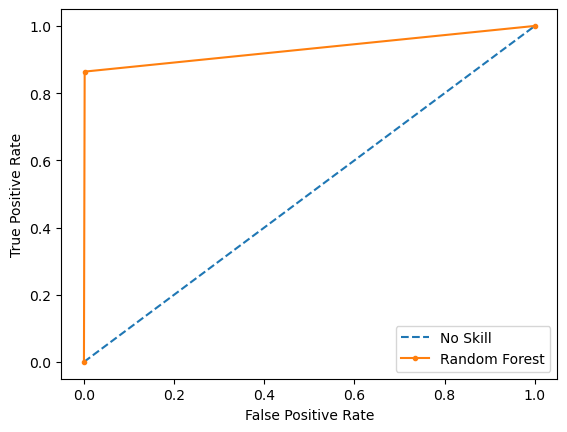

In [50]:
# keep probabilities for the positive outcome only
yhat = ypred_proba_dt[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

La curva no es apropiada para valorar el modelo.

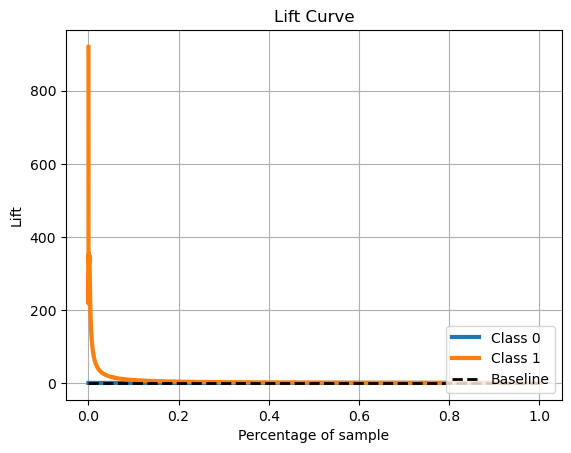

In [44]:
skplt.metrics.plot_lift_curve(y_test, ypred_proba_dt)
plt.show()

La curva muestra un buen modelo.

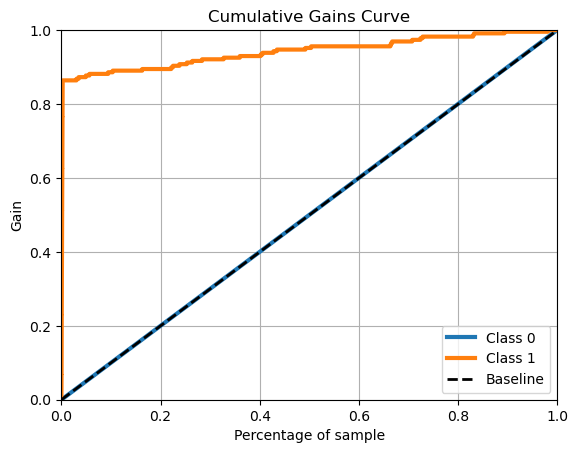

In [45]:
skplt.metrics.plot_cumulative_gain(y_test, ypred_proba_dt)
plt.show()

La curva se aproxima bastante al 1, por lo que es un buen modelo.

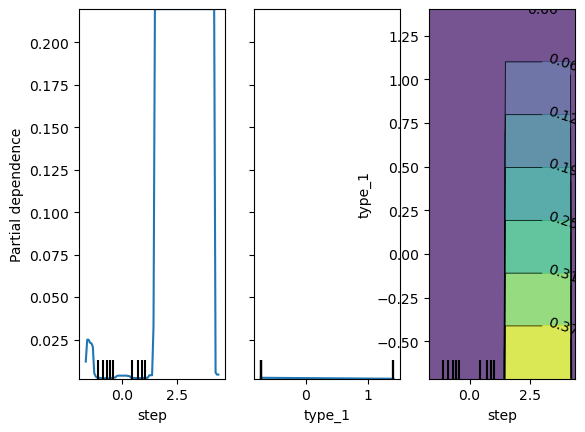

In [49]:
features = [0, 1, (0, 1)]
PartialDependenceDisplay.from_estimator(clf_dt, X_test_scaled, features)

Los coeficientes son mas elevados que la mayoria de modelos que hemos construido. No son los mejores que hemos obtenido, pero si consiguen predecir mas.

In [43]:
with open('../models/Dt_model.pickle', 'wb') as f:
    pickle.dump(clf_dt, f)